In [1]:
# %matplotlib widget
%matplotlib inline

### Plot the Tsys spectrum

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import math

def normalize_array(array, iants, obs_type, normScans=[0,0,0]):

    array_norm = np.full(np.shape(array), fill_value=np.nan)
    iants_uq = np.unique(iants)
    obsType_uq = np.unique(obs_type)
    for iant in iants_uq:
        for i, obs in enumerate(obsType_uq):
            conditions = ((iants == iant) & (obs_type==obs))
            indices = np.where(conditions)
            array_sub = array[indices]
            array_norm[indices] = array_sub / array_sub[normScans[i]]

    return array_norm

def map_series_by_dict(a, d):

    v = np.array(list(d.values()))
    k = np.array(list(d.keys()))
    sidx = k.argsort()
    out_ar = v[sidx[np.searchsorted(k,a,sorter=sidx)]]
    return out_ar

def add_label_band(ax, left, right, label, *, spine_pos=-0.12, tip_pos=-0.09, fontsize=15):
    """
    Helper function to add bracket around x-tick labels.

    Parameters
    ----------
    ax : matplotlib.Axes
        The axes to add the bracket to

    top, bottom : floats
        The positions in *data* space to bracket on the y-axis

    label : str
        The label to add to the bracket

    spine_pos, tip_pos : float, optional
        The position in *axes fraction* of the spine and tips of the bracket.
        These will typically be negative

    Returns
    -------
    bracket : matplotlib.patches.PathPatch
        The "bracket" Aritst.  Modify this Artist to change the color etc of
        the bracket from the defaults.

    txt : matplotlib.text.Text
        The label Artist.  Modify this to change the color etc of the label
        from the defaults.

    """
    # grab the yaxis blended transform
    transform = ax.get_xaxis_transform()

    # add the bracket
    bracket = mpatches.PathPatch(
        mpath.Path(
            [
                [left, tip_pos],
                [left, spine_pos],
                [right, spine_pos],
                [right, tip_pos],
            ]
        ),
        transform=transform,
        clip_on=False,
        facecolor="none",
        edgecolor="k",
        linewidth=2,
    )
    ax.add_artist(bracket)

    # add the label
    txt = ax.text(
        (left + right) / 2,
        spine_pos-0.05,
        label,
        ha="center",
        va="center",
        rotation="horizontal",
        clip_on=False,
        transform=transform,
        fontsize=fontsize
    )

    return bracket, txt

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

def approxCalc(tsrc0,tsrc1,tsrc2,tsrc3,m_el,Tamb=275,r=[1.193,0.399,0.176,0.115],
               tau0=[0.027,0.02,0.01,0.01],eta_c=0.97,verb=True):
    '''
    ------
    Parameters
    tsrc0, tsrc1, tsrc2, tsrc3:
        WVR temperature for channel 0, 1, 2, 3
    m_el: float
        Elevation in degrees
    Tamb: float
        Ambient temperature in Kelvin
    r: list
        ratio of opacity at each filter compared to PWV
    tau0: list
        contribution of the continuum
    eta_c: float
        The forward efficiency of the antenna
    verb: bool
        If true, print out bunch of information
    ------
    Return
    pwv_z: 
        Zenith pwv values
    '''
    m_el=m_el/57.295   # convert to radians
    T_loss=275.0

    if tsrc0 > T_loss: T_loss = tsrc0

    tsrc0=(tsrc0-(1.0-eta_c)*T_loss)/eta_c
    tsrc1=(tsrc1-(1.0-eta_c)*T_loss)/eta_c
    tsrc2=(tsrc2-(1.0-eta_c)*T_loss)/eta_c
    tsrc3=(tsrc3-(1.0-eta_c)*T_loss)/eta_c

    pw=[0.0,0.0,0.0,0.0]; pw_noc=[0.0,0.0,0.0,0.0]
    site="AOS"

    if site=="AOS":
    # approximate physical temp of atmosphere ,based on ambient temperature, Tamb in Kelvin. 
       Tphys=Tamb

    if tsrc0 > Tphys: Tphys = tsrc0
    # if verb: print(site, Tphys)

    tel=[0.0,0.0,0.0,0.0]
    tz=[0.0,0.0,0.0,0.0]
    wt=[0.0,0.0,0.0,0.0]

    # calculates transmissions:
    tel[3]=(1.0-tsrc3/Tphys)
    tel[2]=(1.0-tsrc2/Tphys)
    tel[1]=(1.0-tsrc1/Tphys)
    tel[0]=(1.0-tsrc0/Tphys)

    # if verb: print("Ta:",tsrc0,tsrc1,tsrc2,tsrc3)
    # if verb: print("tel", tel)
    for i in range(4):
        if tel[i]<0.0001: tel[i]=0.0001
        wt[i]=1.0-(abs(tel[i]-0.5)/0.5)**0.5  # weights
    # if verb: print('weights ',wt)
    use=1
    for i in range(4):
           pw[i]=-(np.log(tel[i])+tau0[i])/r[i]
    # if verb: print('uncorrected pwv',pw)

# wet components
    rat31_1=pw[3]/pw[1]
    pwm=np.mean(pw)
    if pwm>0.5:   # only look for a wet cloud component if pwv>0.5mm   (bit arbitrary cutoff but probably ok)
        pwt=np.zeros(4)
        tauc0_0=-0.02
        tauc0=0.01
        i=0
        std_pwt_old=9999.0
        iloop=True
        std_pwt=np.zeros(25);tauc=np.zeros(25)
        while(iloop):
            tauc[i]=tauc0_0 + tauc0*1.17**i-tauc0
            for i1 in range(4):
                pwt[i1]=-(np.log(tel[i1])+tau0[i1]+tauc[i])/r[i1]
                if pwt[i1]<0.0: iloop=False
            mean_pwt,std_pwt[i]=weighted_avg_and_std(pwt, wt)   # get slope of 4 pwv values, using weights (should weight down channels 0,1 a lot)

            if abs(std_pwt[i])>std_pwt_old or (abs(std_pwt[i])/mean_pwt < 0.000001) : iloop=False # stop loop if slope is getting larger, or diff is <0.001%
            # if verb: print('tauc',tauc[i],'std(pwv)',std_pwt[i],'pwv',pwt)
            std_pwt_old=std_pwt[i]
            i+=1
            if i>24: iloop=False


        tau_constant=tauc[i-2]
 #       print 'tauc:',tau_constant    # this is the last but one estimate, before it started increasing again
    else:
        tau_constant=0.0  # default, for low pwv

# re-estimates pwv, after removing additional tau_constant component
    for i in range(4):
           pw_noc[i]=-(np.log(tel[i])+tau0[i]+tau_constant)/r[i]
    # if verb: print('corrected:',pw_noc)
    rat31_2=pw[3]/pw[1]
    ratio31_a=pw[3]/pw[1]

# #  estimates weighted mean pwv, with and without cloud component:
    ws=0.0
    for i in range(4):
          ws=ws+pw[i]*wt[i]
    pwv_los=ws/sum(wt)
    pwv_z=pwv_los*math.sin(m_el)

# wet components
# now optionally remove wet cloud component
    ws=0.0
    for i in range(4):
          ws=ws+pw_noc[i]*wt[i]
    pwv_los_noc=ws/sum(wt)
    pwv_z_noc=pwv_los_noc*math.sin(m_el)
    tau_constant_z=tau_constant      # *math.sin(m_el)   ##!! assume tau_constant is not planar - just the line of sign value (ie don't use sin(elev) )

    return pwv_z


tex_textwidth = 14.2

Directories

In [4]:
Dir = 'C:/Users/haohe/OneDrive - McMaster University/Astrotech/ALMA_intern/'
gitDir = Dir + 'ALMA_intern_Tsys/'
picDir = gitDir+'ATM_modeling/pictures/'

Check the stability of the spectrum for different PWV and airmass (airmass determines the elevation angle)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


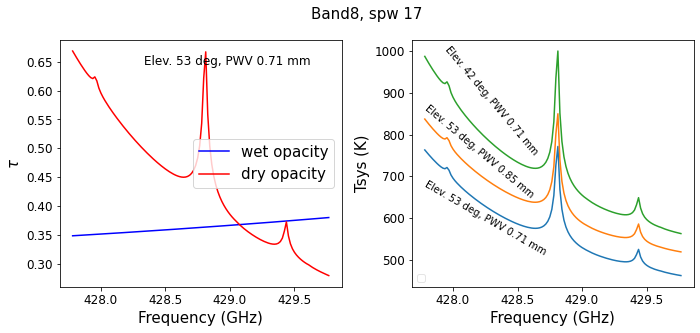

In [4]:
# parameters    
colnames = ['Frequency','dryOpacity','wetOpacity','totalOpacity','transmission','Tsky']
Trx = 100
Feff = 0.99; SBGain = 0.99; Tamb = 274

def plot_Tsys_spectrum(dataLabel, pwv, elevation, ax, **kwarg):
    pwv_str = str(round(pwv, 2))
    elevation_str = str(int(elevation))
    Tsys_spectrum = pd.read_csv('spectrum/Tsys_'+dataLabel+'_spw17_elevation'+str(elevation)+'_pwv'+str(pwv)+'.txt',
                                delimiter=' ',names=colnames,skiprows=1)
    Tsys_spectrum['Tsys'] = (Feff*Tsys_spectrum['Tsky'] + (1.0-Feff)*Tamb + Trx) * \
    (1.0+(1.0-SBGain)) / (Feff*np.exp(-Tsys_spectrum['totalOpacity']))
    ax.plot(Tsys_spectrum['Frequency'], Tsys_spectrum['Tsys'], **kwarg)
    plt.legend(fontsize=10, loc='lower left', framealpha=0.5)
    return

fig = plt.figure(figsize=(0.8*tex_textwidth, 0.4*0.8*tex_textwidth))
ax = plt.subplot(121)
# ax.set_title('Elev. 53 deg, PWV 0.78 mm')
ax.set_xlabel('Frequency (GHz)', fontsize=15)
ax.set_ylabel(r'$\tau$', fontsize=15)
ax.annotate('Elev. 53 deg, PWV 0.71 mm', (0.3, 0.9), xycoords='axes fraction',fontsize=12)
Tsys_spectrum = pd.read_csv('spectrum/Tsys_Band8_spw17_elevation53_pwv0.71.txt',delimiter=' ',names=colnames,skiprows=1)
plt.plot(Tsys_spectrum['Frequency'], Tsys_spectrum['wetOpacity'], color='blue', label='wet opacity')
plt.plot(Tsys_spectrum['Frequency'], Tsys_spectrum['dryOpacity'], color='red', label='dry opacity')
plt.legend(fontsize=15, loc=7)
ax.tick_params(labelsize=12)

ax = plt.subplot(122)
ax.set_ylabel('Tsys (K)', fontsize=15)
ax.set_xlabel('Frequency (GHz)', fontsize=15)
ax.tick_params(labelsize=12)
plot_Tsys_spectrum('Band8', 0.71, 53, ax)
plot_Tsys_spectrum('Band8', 0.85, 53, ax)
plot_Tsys_spectrum('Band8', 0.71, 42, ax)
ax.annotate('Elev. 53 deg, PWV 0.71 mm', (428.25, 600), fontsize=10, rotation=-30, ha='center',va='center')
ax.annotate('Elev. 53 deg, PWV 0.85 mm', (428.2, 760), fontsize=10, rotation=-40, ha='center',va='center')
ax.annotate('Elev. 42 deg, PWV 0.71 mm', (428.3, 880), fontsize=10, rotation=-50, ha='center',va='center')

fig.suptitle('Band8, spw 17', fontsize=15)
plt.subplots_adjust(wspace=0.25)
plt.savefig(picDir+'Tsys_spectrum_Band8.pdf', bbox_inches='tight', pad_inches=0.1)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


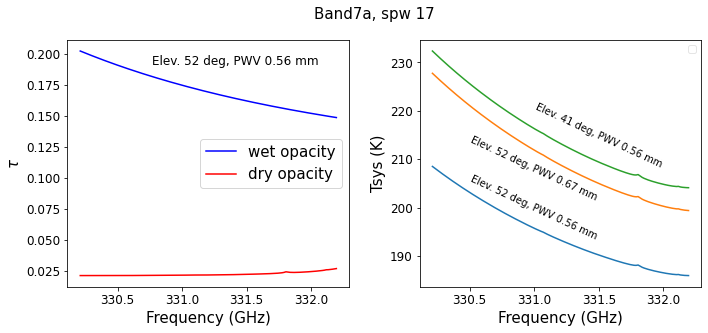

In [5]:
def plot_Tsys_spectrum(dataLabel, pwv, elevation, ax, **kwarg):
    pwv_str = str(round(pwv, 2))
    elevation_str = str(int(elevation))
    Tsys_spectrum = pd.read_csv('spectrum/Tsys_'+dataLabel+'_spw17_elevation'+str(elevation)+'_pwv'+str(pwv)+'.txt',
                                delimiter=' ',names=colnames,skiprows=1)
    Tsys_spectrum['Tsys'] = (Feff*Tsys_spectrum['Tsky'] + (1.0-Feff)*Tamb + Trx) * \
    (1.0+(1.0-SBGain)) / (Feff*np.exp(-Tsys_spectrum['totalOpacity']))
    ax.plot(Tsys_spectrum['Frequency'], Tsys_spectrum['Tsys'], **kwarg)
    plt.legend(fontsize=10, loc='upper right', framealpha=0.5)
    return

fig = plt.figure(figsize=(0.8*tex_textwidth, 0.4*0.8*tex_textwidth))
fig.suptitle('Band7a, spw 17', fontsize=15)
ax = plt.subplot(121)
ax.set_xlabel('Frequency (GHz)', fontsize=15)
ax.set_ylabel(r'$\tau$', fontsize=15)
ax.annotate('Elev. 52 deg, PWV 0.56 mm', (0.3, 0.9), xycoords='axes fraction',fontsize=12)
Tsys_spectrum = pd.read_csv('spectrum/Tsys_Band7a_spw17_elevation52_pwv0.56.txt',delimiter=' ',names=colnames,skiprows=1)
plt.plot(Tsys_spectrum['Frequency'], Tsys_spectrum['wetOpacity'], color='blue', label='wet opacity')
plt.plot(Tsys_spectrum['Frequency'], Tsys_spectrum['dryOpacity'], color='red', label='dry opacity')
plt.legend(fontsize=15, loc=7)
ax.tick_params(labelsize=12)

ax = plt.subplot(122)
ax.set_ylabel('Tsys (K)', fontsize=15)
ax.set_xlabel('Frequency (GHz)', fontsize=15)
ax.tick_params(labelsize=12)
plot_Tsys_spectrum('Band7a', 0.56, 52, ax)
plot_Tsys_spectrum('Band7a', 0.67, 52, ax)
plot_Tsys_spectrum('Band7a', 0.56, 41, ax)
ax.annotate('Elev. 52 deg, PWV 0.56 mm', (331, 200), fontsize=10, rotation=-25, ha='center',va='center')
ax.annotate('Elev. 52 deg, PWV 0.67 mm', (331, 208), fontsize=10, rotation=-25, ha='center',va='center')
ax.annotate('Elev. 41 deg, PWV 0.56 mm', (331.5, 215), fontsize=10, rotation=-25, ha='center',va='center')


plt.subplots_adjust(wspace=0.25)
plt.savefig(picDir+'Tsys_spectrum_Band7a.pdf', bbox_inches='tight', pad_inches=0.1)

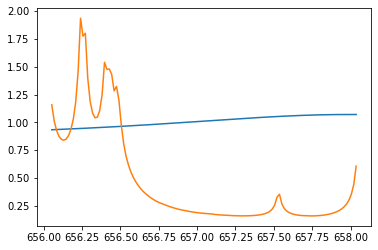

In [6]:
colnames = ['Frequency','dryOpacity','wetOpacity','totalOpacity','transmission','Tsky']

Tsys_spectrum = pd.read_csv('spectrum/Tsys_Band9b1_spw17_elevation38_pwv0.5.txt',delimiter=' ',names=colnames,skiprows=1)
fig = plt.figure()
plt.plot(Tsys_spectrum['Frequency'], Tsys_spectrum['wetOpacity'])
plt.plot(Tsys_spectrum['Frequency'], Tsys_spectrum['dryOpacity'])

## Check how different parameters affect the Tsys vs Twvr correlation

Change the PWV values to see Tsys vs Twvr correlation

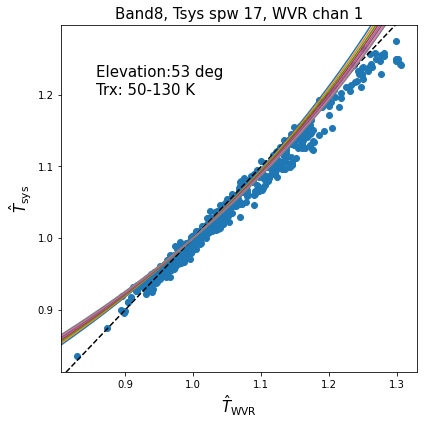

In [7]:
# import the Band8 data
filename = gitDir+'examples/2018.1.01778.S/Tsys_WVR_matched_avgTime10.pkl'
# load the data
with open (filename, 'rb') as pickle_file:
    Tsys_table = pickle.load(pickle_file, encoding='latin')
iants = Tsys_table['iant']
obs_type = Tsys_table['obs_type']
obs_type = obs_type.astype(str)
WVR_sinchan = Tsys_table['WVR_means'][:,1]
Tsys_sinspw = Tsys_table['Tsys'][:,0]

# Normalize Tsys and WVR
Tsys_norm = normalize_array(Tsys_sinspw, iants, obs_type)
WVR_norm = normalize_array(WVR_sinchan, iants, obs_type)

colnames = ['Frequency','dryOpacity','wetOpacity','totalOpacity','transmission','Tsky']
Trx = 100; elevation = 53; airmass = 1/np.sin(np.radians(elevation))
Feff = 0.99; SBGain = 0.99; Tamb = 274
pwvs = np.round(np.arange(0.4, 1.1, 0.01),2)
fig = plt.figure(figsize=(0.45*tex_textwidth,0.45*tex_textwidth))
plt.title('Band8, Tsys spw 17, WVR chan 1', fontsize=15)
ax1 = plt.subplot(111)
ax1.set_xlabel(r'$\hat{T}_{\mathrm{WVR}}$', fontsize=15)
ax1.set_ylabel(r'$\hat{T}_{\mathrm{sys}}$', fontsize=15)
ax1.annotate('Elevation:53 deg\nTrx: 50-130 K', xy=(0.1, 0.8), xycoords='axes fraction', fontsize=15)
# plot the actual data
sc = ax1.scatter(WVR_norm, Tsys_norm)
# ax1.set_xlim(left=0.9)
# plot the 1-to-1 line
lower=max(ax1.set_xlim()[0], ax1.set_ylim()[0])
upper=min(ax1.set_xlim()[1], ax1.set_ylim()[1])
ax1.plot([lower, upper],[lower,upper],ls='--', color='black')
# plot the modeling curves with different Trx values
Trxs = np.arange(50, 130, 10)
for Trx in Trxs:
    ATM_Twvrs = np.array([]); ATM_Tsys = np.array([])
    for pwv in pwvs:
        pwv_str = str(round(pwv, 2))
        ATM_wvr_table = pd.read_csv('spectrum/Twvr_chan1_elevation53_pwv'+pwv_str+'.txt',delimiter=' ',names=colnames,skiprows=1)
        ATM_Twvrs = np.append(ATM_Twvrs, np.mean(ATM_wvr_table['Tsky']))
        # read and average Tsys from spw 17
        ATM_Tsys_table = pd.read_csv('spectrum/Tsys_Band8_spw17_elevation53_pwv'+pwv_str+'.txt', delimiter=' ',names=colnames,skiprows=1)
        ATM_Tsys_table['Tsys'] = (Feff*ATM_Tsys_table['Tsky'] + (1.0-Feff)*Tamb + Trx) * \
        (1.0+(1.0-SBGain)) / (Feff*np.exp(-ATM_Tsys_table['totalOpacity']))
        Tsys_avg = np.mean(ATM_Tsys_table['Tsys'])
        ATM_Tsys = np.append(ATM_Tsys, Tsys_avg)
    norm_idx = np.where(pwvs==0.71)[0]
    ATM_Tsys_norm = ATM_Tsys / ATM_Tsys[norm_idx]
    ATM_Twvr_norm = ATM_Twvrs / ATM_Twvrs[norm_idx]
    ax1.plot(ATM_Twvr_norm, ATM_Tsys_norm, marker=None, label='Trx '+str(Trx))
    
plt.savefig(picDir+'Tsys_Twvr_modeling_Trx.pdf', bbox_inches='tight', pad_inches=0.2)

Change the elevations

### Explore the joint effects from elevation and pwv variation

In [8]:
def plot_Tsys_Twvr_elev_pwv(filename, dataLabel, chan_wvr, m_el_sci0, m_el_bpass, 
                            elevations, pwvs, ax):
    # load the data
    with open (filename, 'rb') as pickle_file:
        Tsys_table = pickle.load(pickle_file, encoding='latin')
    iants = Tsys_table['iant']
    obs_type = Tsys_table['obs_type']
    obs_type = obs_type.astype(str)
    WVR_sinchan = Tsys_table['WVR_means'][:,chan_wvr]
    Tsys_sinspw = Tsys_table['Tsys'][:,0]
    Tsys_sinspw[np.where(Tsys_sinspw<100)] = np.nan # exclude weird values
    Twvr_sinant = Tsys_table['WVR_means'][np.where(iants==0)[0],:]
    Trx_sinant = Tsys_table['Trx'][np.where(iants==0)]
    pwv_sci0 = approxCalc(Twvr_sinant[2,0], Twvr_sinant[2,1], Twvr_sinant[2,2], Twvr_sinant[2,3], m_el_sci0)
    pwv_sci0 = round(pwv_sci0,2)
    print('PWV: '+str(pwv_sci0))
    Trx = Trx_sinant[2,1]
    print('Trx: '+str(Trx))
    # Normalize Tsys and WVR
    obs_type_temp = np.chararray(np.shape(obs_type), itemsize=10, unicode=False)
    obs_type_temp[:] = 'science'
    obs_type_temp = obs_type_temp.astype(str)
    WVR_norm = normalize_array(WVR_sinchan, iants, obs_type_temp, normScans=[2])
    Tsys_norm = normalize_array(Tsys_sinspw, iants, obs_type_temp, normScans=[2])

    colnames = ['Frequency','dryOpacity','wetOpacity','totalOpacity','transmission','Tsky']
    Feff = 0.99; SBGain = 0.99; Tamb = 274
    
#     fig = plt.figure(figsize=(7,5))
#     ax = plt.subplot(111)
#     ax.set_xlabel('Normalized WVR', fontsize=15)
#     ax.set_ylabel('Normalized Tsys', fontsize=15)
    # plot the actual data
    ax.tick_params(labelsize=12)
    color_dict = { 'phase':'green', 'science':'blue', 'bandpass':'orange'}
    legendhandle = [plt.plot([], marker="o", ls="", color=color)[0] for color in list(color_dict.values())]
    plt.legend(legendhandle,list(color_dict.keys()), loc='upper left', framealpha=0.5, fontsize=15)
    sc = ax.scatter(WVR_norm, Tsys_norm, c=map_series_by_dict(obs_type, color_dict))
    # ax.set_xlim(left=0.85)
    # ax.set_ylim(bottom=0.9)
    # plot the 1-to-1 line
    lower=max(ax.set_xlim()[0], ax.set_ylim()[0])
    upper=min(ax.set_xlim()[1], ax.set_ylim()[1])
    ax.plot([lower, upper],[lower,upper],ls='--', color='black')
    pwv = pwv_sci0
    norm_idx = np.where(elevations==m_el_sci0)
    pwv_str = str(round(pwv, 2))
    ATM_Twvrs = np.array([]); ATM_Tsys = np.array([])
    for elevation in elevations:
        elevation_str = str(int(elevation))
        airmass = 1/np.sin(np.radians(elevation))
        ATM_wvr_table = pd.read_csv('spectrum/Twvr_chan'+str(chan_wvr)+'_elevation'+elevation_str+'_pwv'+pwv_str+'.txt',
                                    delimiter=' ',names=colnames,skiprows=1)
        ATM_Twvrs = np.append(ATM_Twvrs, np.mean(ATM_wvr_table['Tsky']))
        # read and average Tsys from spw 17
        ATM_Tsys_table = pd.read_csv('spectrum/Tsys_'+dataLabel+'_spw17_elevation'+elevation_str+'_pwv'+pwv_str+'.txt', 
                                     delimiter=' ',names=colnames,skiprows=1)
        ATM_Tsys_table['Tsys'] = (Feff*ATM_Tsys_table['Tsky'] + (1.0-Feff)*Tamb + Trx) * \
        (1.0+(1.0-SBGain)) / (Feff*np.exp(-ATM_Tsys_table['totalOpacity']))
        Tsys_avg = np.mean(ATM_Tsys_table['Tsys'])
        ATM_Tsys = np.append(ATM_Tsys, Tsys_avg)
    ATM_Tsys_norm = ATM_Tsys / ATM_Tsys[norm_idx]
    ATM_Twvr_norm = ATM_Twvrs / ATM_Twvrs[norm_idx]
    ax.plot(ATM_Twvr_norm, ATM_Tsys_norm, marker='None', linewidth=3, color='magenta') 
    # plot the normalized PWV for elevation angles
    elevation = m_el_sci0
    elevation_str = str(elevation)
    norm_idx = np.where(pwvs==pwv_sci0)
    ATM_Twvrs1 = np.array([]); ATM_Tsys1 = np.array([])
    for pwv in pwvs:
        pwv_str = str(round(pwv, 2))
        airmass = 1/np.sin(np.radians(elevation))
        ATM_wvr_table = pd.read_csv('spectrum/Twvr_chan'+str(chan_wvr)+'_elevation'+elevation_str+'_pwv'+pwv_str+'.txt',
                                    delimiter=' ',names=colnames,skiprows=1)
        ATM_Twvrs1 = np.append(ATM_Twvrs1, np.mean(ATM_wvr_table['Tsky']))
        # read and average Tsys from spw 17
        ATM_Tsys_table = pd.read_csv('spectrum/Tsys_'+dataLabel+'_spw17_elevation'+elevation_str+'_pwv'+pwv_str+'.txt', 
                                     delimiter=' ',names=colnames,skiprows=1)
        ATM_Tsys_table['Tsys'] = (Feff*ATM_Tsys_table['Tsky'] + (1.0-Feff)*Tamb + Trx) * \
        (1.0+(1.0-SBGain)) / (Feff*np.exp(-ATM_Tsys_table['totalOpacity']))
        Tsys_avg = np.mean(ATM_Tsys_table['Tsys'])
        ATM_Tsys1 = np.append(ATM_Tsys1, Tsys_avg)
    ATM_Tsys_norm1 = ATM_Tsys1 / ATM_Tsys1[norm_idx]
    ATM_Twvr_norm1 = ATM_Twvrs1 / ATM_Twvrs1[norm_idx]
    ax.plot(ATM_Twvr_norm1, ATM_Tsys_norm1, marker='None', linewidth=3, color='red') 
    # bandpass elevation of 44 deg
    elevation = m_el_bpass
    elevation_str = str(elevation)
    ATM_Twvrs2 = np.array([]); ATM_Tsys2 = np.array([])
    for pwv in pwvs:
        pwv_str = str(round(pwv, 2))
        airmass = 1/np.sin(np.radians(elevation))
        ATM_wvr_table = pd.read_csv('spectrum/Twvr_chan'+str(chan_wvr)+'_elevation'+elevation_str+'_pwv'+pwv_str+'.txt',
                                    delimiter=' ',names=colnames,skiprows=1)
        ATM_Twvrs2 = np.append(ATM_Twvrs2, np.mean(ATM_wvr_table['Tsky']))
        # read and average Tsys from spw 17
        ATM_Tsys_table = pd.read_csv('spectrum/Tsys_'+str(dataLabel)+'_spw17_elevation'+elevation_str+'_pwv'+pwv_str+'.txt', 
                                     delimiter=' ',names=colnames,skiprows=1)
        ATM_Tsys_table['Tsys'] = (Feff*ATM_Tsys_table['Tsky'] + (1.0-Feff)*Tamb + Trx) * \
        (1.0+(1.0-SBGain)) / (Feff*np.exp(-ATM_Tsys_table['totalOpacity']))
        Tsys_avg = np.mean(ATM_Tsys_table['Tsys'])
        ATM_Tsys2 = np.append(ATM_Tsys2, Tsys_avg)
    ATM_Tsys_norm2 = ATM_Tsys2 / ATM_Tsys1[norm_idx]
    ATM_Twvr_norm2 = ATM_Twvrs2 / ATM_Twvrs1[norm_idx]
    ax.plot(ATM_Twvr_norm2, ATM_Tsys_norm2, marker='None', linewidth=3, color='red') 
    
    return ax

PWV: 0.71
Trx: 105.51717066360732
PWV: 0.56
Trx: 63.86441090147374


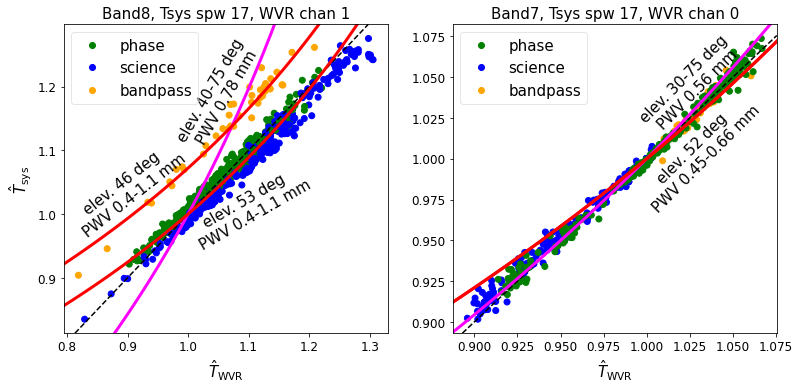

In [9]:
fig = plt.figure(figsize=(0.9*tex_textwidth,0.4*tex_textwidth))
figname = picDir+'Tsys_Twvr_ATM_pwv_elev.pdf'
# Plot Band8 data
ax = plt.subplot(121)
filename = gitDir+'examples/2018.1.01778.S/Tsys_WVR_matched_avgTime10.pkl'
dataLabel = 'Band8'
chan_wvr = 1
m_el_sci0 = 53; m_el_bpass = 46
elevations = np.arange(40, 75, 1)
pwvs = np.round(np.arange(0.4, 1.1, 0.01),2)
plot_Tsys_Twvr_elev_pwv(filename, dataLabel, chan_wvr, m_el_sci0, m_el_bpass, elevations, pwvs, ax)
plt.title('Band8, Tsys spw 17, WVR chan 1', fontsize=15)
plt.annotate('elev. 46 deg\n PWV 0.4-1.1 mm', (0.9,0.96), fontsize=15, rotation=38, ha='center')
plt.annotate('elev. 53 deg\n PWV 0.4-1.1 mm', (1.1,0.94), fontsize=15, rotation=30, ha='center')
plt.annotate('elev. 40-75 deg\n PWV 0.78 mm', (1.05,1.1), fontsize=15, rotation=60, ha='center')

ax.set_xlabel('$\hat{T}_{\mathrm{WVR}}$', fontsize=15)
ax.set_ylabel('$\hat{T}_{\mathrm{sys}}$', fontsize=15)

# Plot Band7a data
ax = plt.subplot(122)
plt.title('Band7, Tsys spw 17, WVR chan 0', fontsize=15)
# parameters
filename = gitDir+'examples/E2E8.1.00003.S/Tsys_WVR_matched_avgTime10.pkl'
dataLabel = 'Band7a'
chan_wvr = 0
m_el_sci0 = 52; m_el_bpass = 52
elevations = np.arange(30,75,1)
pwvs = np.round(np.arange(0.45, 0.66, 0.01),2)
plot_Tsys_Twvr_elev_pwv(filename, dataLabel, chan_wvr, m_el_sci0, m_el_bpass, elevations, pwvs, ax)
plt.annotate('elev. 52 deg\n PWV 0.45-0.66 mm', (1.03, 0.965), fontsize=15, rotation=45, ha='center')
plt.annotate('elev. 30-75 deg\n PWV 0.56 mm', (1.025,1.015), fontsize=15, rotation=45, ha='center')
ax.set_xlabel('$\hat{T}_{\mathrm{WVR}}$', fontsize=15)

plt.savefig(figname, bbox_inches='tight', pad_inches=0.2)

#### Band 9b1 data

PWV: 0.4
Trx: 68.67466679265944


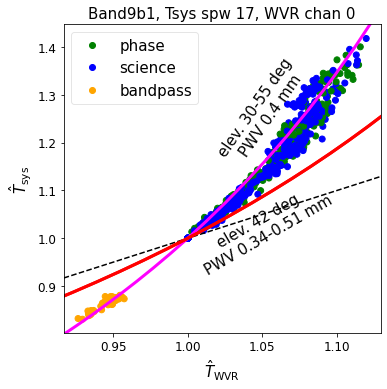

In [10]:
fig = plt.figure(figsize=(0.4*tex_textwidth,0.4*tex_textwidth))
figname = picDir+'Tsys_Twvr_ATM_pwv_elev_Band9b1.pdf'
ax = plt.subplot(111)
plt.title('Band9b1, Tsys spw 17, WVR chan 0', fontsize=15)
# parameters
filename = gitDir+'examples/2019.1.00013.S/X769c/Tsys_WVR_matched_avgTime10.pkl'
dataLabel = 'Band9b1'
chan_wvr = 0
m_el_sci0 = 42; m_el_bpass = 42
elevations = np.arange(30,55,1)
pwvs = np.round(np.arange(0.34, 0.51, 0.01),2)

plot_Tsys_Twvr_elev_pwv(filename, dataLabel, chan_wvr, m_el_sci0, m_el_bpass, elevations, pwvs, ax)
plt.annotate('elev. 42 deg\n PWV 0.34-0.51 mm', (1.05,0.92), fontsize=15, rotation=30, ha='center')
plt.annotate('elev. 30-55 deg\n PWV 0.4 mm', (1.05,1.15), fontsize=15, rotation=55, ha='center')

ax.set_xlabel('$\hat{T}_{\mathrm{WVR}}$', fontsize=15)
ax.set_ylabel('$\hat{T}_{\mathrm{sys}}$', fontsize=15)

plt.savefig(figname, bbox_inches='tight', pad_inches=0.2)

### Individual examples

In [11]:
colnames = ['Frequency','dryOpacity','wetOpacity','totalOpacity','transmission','Tsky']
Twvrs = np.array([]); Tsys_avgs = np.array([])
Trx = 100; elevation = 53; airmass = 1/np.sin(np.radians(elevation))
Feff = 0.99; SBGain = 0.99; Tamb = 270
pwvs = np.arange(0.6, 1.0, 0.01)
for pwv in pwvs:
    pwv_str = str(round(pwv, 2))
    Twvr_table = pd.read_csv('spectrum/Band8_Twvr_elevation53_pwv'+pwv_str+'_chan1.txt',delimiter=' ',names=colnames,skiprows=1)
    Twvrs = np.append(Twvrs, np.mean(Twvr_table['Tsky']))
    # read and average Tsys from spw 17
    Tsys_table = pd.read_csv('spectrum/Band8_Tsys_elevation53_pwv'+pwv_str+'_spw17.txt',delimiter=' ',names=colnames,skiprows=1)
    Tsys_table['Tsys'] = (Feff*Tsys_table['Tsky'] + (1.0-Feff)*Tamb + Trx) * \
    (1.0+(1.0-SBGain)) / (Feff*np.exp(-airmass*Tsys_table['totalOpacity']))
    Tsys_avg = np.mean(Tsys_table['Tsys'])
    Tsys_avgs = np.append(Tsys_avgs, Tsys_avg)

Twvrs_norm = Twvrs / Twvrs[0]
Tsys_norm = Tsys_avgs / Tsys_avgs[0]
fig = plt.figure(figsize=(10,4))
ax = plt.subplot(121)
ax.set_xlabel('Twvr (K)', fontsize=15)
ax.set_ylabel('Tsys (K)', fontsize=15)
plt.scatter(Twvrs, Tsys_avgs)
ax = plt.subplot(122)
ax.set_xlabel('Norm. Twvr', fontsize=15)
ax.set_ylabel('Norm. Tsys', fontsize=15)
plt.scatter(Twvrs_norm, Tsys_norm)
ax.set_xlim(); ax.set_ylim()
ax.plot([0,2], [0,2], linestyle='dashed')
x = np.array([0,2])
y = 1.52321972*x - 0.52588968
ax.plot(x, y)

FileNotFoundError: [Errno 2] No such file or directory: 'spectrum/Band8_Twvr_elevation53_pwv0.6_chan1.txt'

## Modeling for entire frequency coverage

### The dry and wet opacity contribution at different frequencies

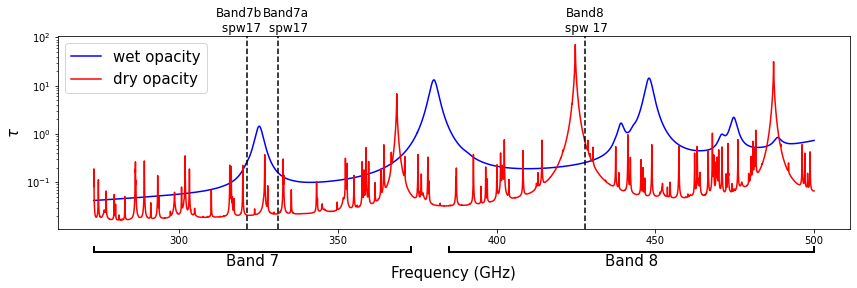

In [12]:
colnames = ['Frequency','dryOpacity','wetOpacity','totalOpacity','transmission','Tsky']
Tsys_Band7 = pd.read_csv('spectrum/ATM_Band7_elevation50_pwv0.5.txt',delimiter=' ',names=colnames,skiprows=1)

colnames = ['Frequency','dryOpacity','wetOpacity','totalOpacity','transmission','Tsky']
Tsys_Band8 = pd.read_csv('spectrum/ATM_Band8_elevation50_pwv0.5.txt',delimiter=' ',names=colnames,skiprows=1)

fig = plt.figure(figsize=(tex_textwidth, 0.25*tex_textwidth))
ax = plt.subplot(111)
plt.plot(Tsys_Band7['Frequency'], Tsys_Band7['wetOpacity'], color='blue')
plt.plot(Tsys_Band8['Frequency'], Tsys_Band8['wetOpacity'], color='blue', label='wet opacity')
plt.plot(Tsys_Band7['Frequency'], Tsys_Band7['dryOpacity'], color='red')
plt.plot(Tsys_Band8['Frequency'], Tsys_Band8['dryOpacity'], color='red', label='dry opacity')
plt.yscale('log')
# add the label for different frequencies
add_label_band(ax, 273, 373, "Band 7")
add_label_band(ax, 385, 500, "Band 8")
# add the axis label
plt.xlabel('Frequency (GHz)', fontsize=15, labelpad=20)
plt.ylabel(r'$\tau$', fontsize=15)
# add the observed frequency
labels = ['Band8\n spw 17', 'Band7a\n spw17', 'Band7b\n spw17']
frequencies = np.array([427.758096, 331.187213, 321.338312])
offsets = [0,2.5,-2.5]
for i, label in enumerate(labels):
    ax.axvline(frequencies[i], linestyle='dashed', color='black')
    ax.text(frequencies[i]+offsets[i], ax.set_ylim()[1]*1.2, labels[i], ha="center", fontsize=12)
# add the legend
plt.legend(fontsize=15)
plt.savefig(picDir+'tau_ATM_Band78.pdf', bbox_inches='tight', pad_inches=0.2)

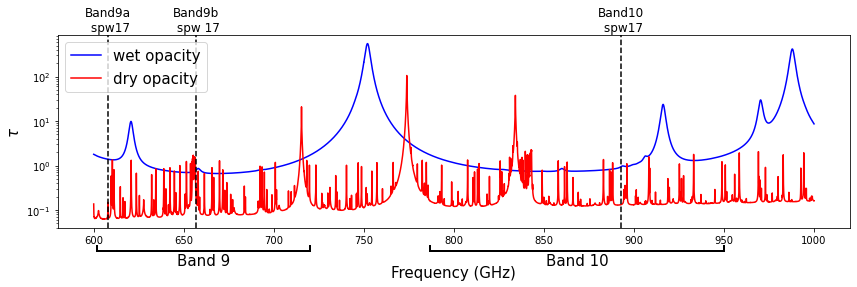

In [5]:
colnames = ['Frequency','dryOpacity','wetOpacity','totalOpacity','transmission','Tsky']
Tsys_Band9 = pd.read_csv('spectrum/ATM_Band9_elevation50_pwv0.5.txt',delimiter=' ',names=colnames,skiprows=1)

colnames = ['Frequency','dryOpacity','wetOpacity','totalOpacity','transmission','Tsky']
Tsys_Band10 = pd.read_csv('spectrum/ATM_Band10_elevation50_pwv0.5.txt',delimiter=' ',names=colnames,skiprows=1)

fig = plt.figure(figsize=(tex_textwidth, 0.25*tex_textwidth))
ax = plt.subplot(111)
plt.plot(Tsys_Band9['Frequency'], Tsys_Band9['wetOpacity'], color='blue')
plt.plot(Tsys_Band10['Frequency'], Tsys_Band10['wetOpacity'], color='blue', label='wet opacity')
plt.plot(Tsys_Band9['Frequency'], Tsys_Band9['dryOpacity'], color='red')
plt.plot(Tsys_Band10['Frequency'], Tsys_Band10['dryOpacity'], color='red', label='dry opacity')
plt.yscale('log')
# add the label for different frequencies
add_label_band(ax, 602, 720, "Band 9")
add_label_band(ax, 787, 950, "Band 10")
# add the axis label
plt.xlabel('Frequency (GHz)', fontsize=15, labelpad=20)
plt.ylabel(r'$\tau$', fontsize=15)
# add the observed frequency
labels = ['Band9b\n spw 17', 'Band9a\n spw17', 'Band10\n spw17']
frequencies = np.array([657.028878, 608.068925, 893.056999])
offsets = [0,0,0]
for i, label in enumerate(labels):
    ax.axvline(frequencies[i], linestyle='dashed', color='black')
    ax.text(frequencies[i]+offsets[i], ax.set_ylim()[1]*1.2, labels[i], ha="center", fontsize=12)
# add the legend
plt.legend(fontsize=15)
plt.savefig(picDir+'tau_ATM_Band910.pdf', bbox_inches='tight', pad_inches=0.2)

### Explore the scale when the linear relation holds for data